# PHÂN TÍCH CHẤT LƯỢNG RƯỢU TRẮNG

Thành viên:
- 23C24004 - Lê Nhựt Nam
- 23C24005 - Phạm Thừa Tiểu Thành

## Giới thiệu chung

## Bảng phân công công việc

## Phát biểu bài toán

## Giới thiệu về dữ liệu

## Import thư viện

In [1]:
library(dplyr)
library(tidyr)
library(car)
library(readxl)
library(mice)
library(VIM)
library(grid)
library(ggplot2)
library(cowplot)
library(missMDA)
library(FactoMineR)
library(TidyDensity)
library(MASS)
library(leaps)
library(lmtest)
library(Metrics)
library(MLmetrics)
library(pls)
# library(caret)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep



== Welcome to TidyDensity ===========================================================================
If you find this package useful, please leave a star: 
   https://github.com/spsanderson/TidyDensity'

If you enco

## Hàm phụ trợ

In [2]:
# Hàm tiền xử lý dữ liệu với box-cox
bc_transform <- function(df) {
    col.names <- names(df)

    transformed_df <- df
    
    for (name in names(df))
    {
        col.name <- name

        print(col.name)

        # Rút trích biến phản hồi
        response_variable <- df[[col.name]]
        
        if (!is.numeric(response_variable)) {
            print(col.name)
            stop("The column to be transformed must be numeric.")
        }
        
        if (any(response_variable <= 0)) {
            # Shift the values to be positive
            shift_value <- abs(min(response_variable)) + 1
            response_variable <- response_variable + shift_value
        }
        
        # Áp dụng box-cox transform để tìm lambda tối ưu
        boxcox_result <- boxcox(lm(response_variable ~ 1), plotit = FALSE)
        optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
        print(paste("Optimal lambda:", optimal_lambda))
        
        # Sử dụng lambda tối ưu để biến đổi dữ liệu
        if (optimal_lambda == 0) {
            transformed_response <- log(response_variable)
        } else {
            transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
        }
        
        # Gán biến đã được biến đổi
        transformed_df[[col.name]] <- transformed_response
    }
    
    return(transformed_df)
}

indicator <- function(model, y_pred, y_true) {
     adj.r.sq <- summary(model)$adj.r.squared
     mse <- MSE(y_pred, y_true)
     rmse <- RMSE(y_pred, y_true)
     mae <- MAE(y_pred, y_true)
     print(paste0("Adjusted R-squared: ", round(adj.r.sq, 4)))
     print(paste0("MSE: ", round(mse, 4)))
     print(paste0("RMSE: ", round(rmse, 4)))
     print(paste0("MAE: ", round(mae, 4)))
}


metrics <- function(y_pred, y_true){
     mse <- MSE(y_pred, y_true)
     rmse <- RMSE(y_pred, y_true)
     mae <- MAE(y_pred, y_true)
     print(paste0("MSE: ", round(mse, 6)))
     print(paste0("RMSE: ", round(rmse, 6)))
     print(paste0("MAE: ", round(mae, 6)))
     corPredAct <- cor(y_pred, y_true)
     print(paste0("Correlation: ", round(corPredAct, 6)))
     print(paste0("R^2 between y_pred & y_true: ", round(corPredAct^2, 6)))
}

CheckNormal <- function(model) {
     hist(model$residuals, breaks = 30)
     shaptest <- shapiro.test(model$residuals)
     print(shaptest)
     if (shaptest$p.value <= 0.05) {
          print("H0 rejected: the residuals are NOT distributed normally")
     } else {
          print("H0 failed to reject: the residuals ARE distributed normally")
     }
}

CheckHomos <- function(model){
     plot(model$fitted.values, model$residuals)
     abline(h = 0, col = "red")
     BP <- bptest(model)
     print(BP)
     if (BP$p.value <= 0.05) {
          print("H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)")
     } else {
          print("H0 failed to reject: Error variance spreads CONSTANTLY (Homoscedasticity)")
     }
}

## Đọc dữ liệu

In [3]:
# Đọc dữ liệu từ tập tin
raw_data = read.table("../../data/part2/wine+quality/winequality-white.csv", header=TRUE, sep=";", stringsAsFactors = FALSE)
str(raw_data)

'data.frame':	4898 obs. of  12 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  20.7 1.6 6.9 8.5 8.5 6.9 7 20.7 1.6 1.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ free.sulfur.dioxide : num  45 14 30 47 47 30 30 45 14 28 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ density             : num  1.001 0.994 0.995 0.996 0.996 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : int  6 6 6 6 6 6 6 6 6 6 ...


In [4]:
# # Specify the path to your .names file
# file_path <- "../../data/part2/wine+quality/winequality.names"

# # Read the .names file
# names_content <- readLines(file_path)

# # Extract the title
# title <- names_content[grepl("Title:", names_content)]
# # print(title)

# # Extract the sources
# sources <- names_content[grepl("Sources", names_content):(which(names_content == "")[1] - 1)]
# # print(sources)

# # Extract the attribute information
# attribute_info_start <- which(grepl("Attribute information:", names_content))
# attribute_info <- names_content[(attribute_info_start + 1):(attribute_info_start + 11)]
# # print(attribute_info)

# # Extract the number of instances
# num_instances <- names_content[grepl("Number of Instances:", names_content)]
# print(num_instances)

# # Extract the number of attributes
# num_attributes <- names_content[grepl("Number of Attributes:", names_content)]
# print(num_attributes)

# # Extract the missing attribute values
# missing_values <- names_content[grepl("Missing Attribute Values:", names_content)]
# print(missing_values)

## Khám phá và tiền xử lý dữ liệu

### Dữ liệu có bao nhiều dòng và bao nhiêu cột?

In [5]:
# Kích thước của dữ liệu
# Ta thấy dữ liệu có 4898 dòng và 12 cột
dim(raw_data)

[1] 4898   12

### Mỗi dòng có ý nghĩa gì? Liệu có tồn tại dòng nào mà mang ý nghĩa khác với các dòng còn lại không?

Dựa trên thông tin của tập dữ liệu, ta thấy mỗi dòng mang ý nghĩa khác nhau, tức là mỗi quan trắc độc lập nhau.

### Dữ liệu có bị trùng lặp không?

In [6]:
# Kiểm tra dữ liệu trùng lặp
duplicates <- raw_data[duplicated(raw_data), ]
duplicate_counts <- (raw_data[duplicated(raw_data), ])
length(duplicates)

[1] 12

In [7]:
clean_data <- unique(raw_data)

In [8]:
duplicates <- clean_data[duplicated(clean_data), ]
if (nrow(duplicates) == 0) {
  print("No duplicates found. Data is clean.")
} else {
  print("Duplicates still exist:")
  print(duplicates)
}

dim(raw_data)
dim(clean_data)

[1] "No duplicates found. Data is clean."


[1] 4898   12

[1] 3961   12

### Mỗi cột mang ý nghĩa gì?

In [9]:
# Đầu tiên, ta xem xét một số quan trắc
str(raw_data)

'data.frame':	4898 obs. of  12 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  20.7 1.6 6.9 8.5 8.5 6.9 7 20.7 1.6 1.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ free.sulfur.dioxide : num  45 14 30 47 47 30 30 45 14 28 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ density             : num  1.001 0.994 0.995 0.996 0.996 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : int  6 6 6 6 6 6 6 6 6 6 ...


### Có cột nào có kiểu dữ liệu chưa phù hợp? Nếu có, cần chuyển đổi sang kiểu phù hợp

In [10]:
wine_quality_white <- raw_data

### Các cột với kiểu dữ liệu số phân bố như thế nào?

In [11]:
# Hàm tính toán tỷ lệ missing value
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

# Hàm tính toán trung vị (median)
median_custom <- function(df) {
  round(quantile(df, 0.5, na.rm = TRUE), 1)
}

# Hàm tính toán phân vị 25% (Q1)
lower_quartile <- function(df) {
  round(quantile(df, 0.25, na.rm = TRUE), 1)
}

# Hàm tính toán phân vị 75% (Q3)
upper_quartile <- function(df) {
  round(quantile(df, 0.75, na.rm = TRUE), 1)
}

In [12]:
# Lựa chọn những cột kiểu số
num_col_info_df <- as.data.frame(wine_quality_white) %>% select_if(is.numeric)

# Tổng hợp các kết quả thống kê
num_col_info_df <- as.data.frame(wine_quality_white) %>%
  select_if(is.numeric) %>%
  summarise(
    across(everything(), list(
      missing_ratio = ~ missing_ratio(.),
      min = ~ min(., na.rm = TRUE),
      lower_quartile = ~ lower_quartile(.),
      median = ~ median_custom(.),
      upper_quartile = ~ upper_quartile(.),
      max = ~ max(., na.rm = TRUE)
    ))
  )

num_col_info_df <- num_col_info_df %>%
  pivot_longer(
    cols = everything(),
    names_to = c("variable", ".value"),
    names_sep = "_"
  )

# In kết quả ra
print(num_col_info_df)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 36 rows [1, 3, 5, 7, 9, 11,
13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, ...].”


# A tibble: 12 × 7
   variable             missing   min lower median upper     max
   <chr>                  <dbl> <dbl> <dbl>  <dbl> <dbl>   <dbl>
 1 fixed.acidity              0 3.8     6.3    6.8   7.3  14.2  
 2 volatile.acidity           0 0.08    0.2    0.3   0.3   1.1  
 3 citric.acid                0 0       0.3    0.3   0.4   1.66 
 4 residual.sugar             0 0.6     1.7    5.2   9.9  65.8  
 5 chlorides                  0 0.009   0      0     0     0.346
 6 free.sulfur.dioxide        0 2      23     34    46   289    
 7 total.sulfur.dioxide       0 9     108    134   167   440    
 8 density                    0 0.987   1      1     1     1.04 
 9 pH                         0 2.72    3.1    3.2   3.3   3.82 
10 sulphates                  0 0.22    0.4    0.5   0.6   1.08 
11 alcohol                    0 8       9.5   10.4  11.4  14.2  
12 quality                    0 3       5      6     6     9    


In [13]:
print(summary(as.data.frame(wine_quality_white) %>% select_if(is.numeric)))

 fixed.acidity    volatile.acidity  citric.acid     residual.sugar  
 Min.   : 3.800   Min.   :0.0800   Min.   :0.0000   Min.   : 0.600  
 1st Qu.: 6.300   1st Qu.:0.2100   1st Qu.:0.2700   1st Qu.: 1.700  
 Median : 6.800   Median :0.2600   Median :0.3200   Median : 5.200  
 Mean   : 6.855   Mean   :0.2782   Mean   :0.3342   Mean   : 6.391  
 3rd Qu.: 7.300   3rd Qu.:0.3200   3rd Qu.:0.3900   3rd Qu.: 9.900  
 Max.   :14.200   Max.   :1.1000   Max.   :1.6600   Max.   :65.800  
   chlorides       free.sulfur.dioxide total.sulfur.dioxide    density      
 Min.   :0.00900   Min.   :  2.00      Min.   :  9.0        Min.   :0.9871  
 1st Qu.:0.03600   1st Qu.: 23.00      1st Qu.:108.0        1st Qu.:0.9917  
 Median :0.04300   Median : 34.00      Median :134.0        Median :0.9937  
 Mean   :0.04577   Mean   : 35.31      Mean   :138.4        Mean   :0.9940  
 3rd Qu.:0.05000   3rd Qu.: 46.00      3rd Qu.:167.0        3rd Qu.:0.9961  
 Max.   :0.34600   Max.   :289.00      Max.   :440.0   

### Các cột với kiểu dữ liệu phân loại phân bố như thế nào?

## Xử lý đa cộng tuyến

In [14]:
cor_matrix <- round(cor(wine_quality_white), 2)
cor_matrix

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
fixed.acidity,1.00,-0.02,0.29,0.09,0.02,-0.05,0.09,0.27,-0.43,-0.02,-0.12,-0.11
volatile.acidity,-0.02,1.00,-0.15,0.06,0.07,-0.10,0.09,0.03,-0.03,-0.04,0.07,-0.19
citric.acid,0.29,-0.15,1.00,0.09,0.11,0.09,0.12,0.15,-0.16,0.06,-0.08,-0.01
residual.sugar,0.09,0.06,0.09,1.00,0.09,0.30,0.40,0.84,-0.19,-0.03,-0.45,-0.10
chlorides,0.02,0.07,0.11,0.09,1.00,0.10,0.20,0.26,-0.09,0.02,-0.36,-0.21
free.sulfur.dioxide,-0.05,-0.10,0.09,0.30,0.10,1.00,0.62,0.29,0.00,0.06,-0.25,0.01
total.sulfur.dioxide,0.09,0.09,0.12,0.40,0.20,0.62,1.00,0.53,0.00,0.13,-0.45,-0.17
density,0.27,0.03,0.15,0.84,0.26,0.29,0.53,1.00,-0.09,0.07,-0.78,-0.31
pH,-0.43,-0.03,-0.16,-0.19,-0.09,0.00,0.00,-0.09,1.00,0.16,0.12,0.10
sulphates,-0.02,-0.04,0.06,-0.03,0.02,0.06,0.13,0.07,0.16,1.00,-0.02,0.05


In [15]:
threshold <- 0.7
high_cor_pairs <- list()

for(i in 1:(nrow(cor_matrix)-1)) {
  for(j in (i+1):ncol(cor_matrix)) {
    if(abs(cor_matrix[i, j]) > threshold) {
      high_cor_pairs <- rbind(high_cor_pairs, 
                              data.frame(Var1 = rownames(cor_matrix)[i], 
                                         Var2 = colnames(cor_matrix)[j], 
                                         value = cor_matrix[i, j]))
    }
  }
}

print(high_cor_pairs)

            Var1    Var2 value
1 residual.sugar density  0.84
2        density alcohol -0.78


In [16]:
threshold <- -0.7

neg_cor_pairs <- list()

for(i in 1:(nrow(cor_matrix)-1)) {
  for(j in (i+1):ncol(cor_matrix)) {
    if(cor_matrix[i, j] < threshold) {
      neg_cor_pairs <- rbind(neg_cor_pairs, 
                             data.frame(Var1 = rownames(cor_matrix)[i], 
                                        Var2 = colnames(cor_matrix)[j], 
                                        value = cor_matrix[i, j]))
    }
  }
}

print(neg_cor_pairs)

     Var1    Var2 value
1 density alcohol -0.78


In [17]:
model <- lm(quality ~ ., data = wine_quality_white)
vif_values <- vif(model)
print(vif_values)

       fixed.acidity     volatile.acidity          citric.acid 
            2.691435             1.141156             1.165215 
      residual.sugar            chlorides  free.sulfur.dioxide 
           12.644064             1.236822             1.787880 
total.sulfur.dioxide              density                   pH 
            2.239233            28.232546             2.196362 
           sulphates              alcohol 
            1.138540             7.706957 


In [18]:
threshold <- 3
while (any(vif_values > threshold)) {
  highest_vif <- which.max(vif_values)
  variable_to_remove <- names(vif_values)[highest_vif]
  formula <- as.formula(paste("quality ~ . -", variable_to_remove))
  model <- update(model, formula)
  vif_values <- vif(model)
}

In [19]:
print(vif_values)
summary(model)

       fixed.acidity     volatile.acidity          citric.acid 
            1.356128             1.128298             1.159884 
      residual.sugar            chlorides  free.sulfur.dioxide 
            1.435215             1.203645             1.744627 
total.sulfur.dioxide                   pH            sulphates 
            2.153170             1.330912             1.056637 
             alcohol 
            1.647117 



Call:
lm(formula = quality ~ fixed.acidity + volatile.acidity + citric.acid + 
    residual.sugar + chlorides + free.sulfur.dioxide + total.sulfur.dioxide + 
    pH + sulphates + alcohol, data = wine_quality_red)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9098 -0.4957 -0.0330  0.4666  3.1785 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           2.0636371  0.3482321   5.926 3.32e-09 ***
fixed.acidity        -0.0503197  0.0149092  -3.375 0.000744 ***
volatile.acidity     -1.9583442  0.1138553 -17.200  < 2e-16 ***
citric.acid          -0.0289483  0.0961455  -0.301 0.763360    
residual.sugar        0.0256438  0.0025518  10.049  < 2e-16 ***
chlorides            -0.9525303  0.5425208  -1.756 0.079194 .  
free.sulfur.dioxide   0.0047672  0.0008391   5.682 1.41e-08 ***
total.sulfur.dioxide -0.0008697  0.0003730  -2.331 0.019771 *  
pH                    0.1651688  0.0825418   2.001 0.045444 *  
sulphates             0.4193440  0.09

In [20]:
clean_df <- wine_quality_white[,names((vif_values))]
clean_df$quality <- wine_quality_white$quality
head(clean_df)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,7.0,0.27,0.36,20.7,0.045,45,170,3.00,0.45,8.8,6
2,6.3,0.30,0.34,1.6,0.049,14,132,3.30,0.49,9.5,6
3,8.1,0.28,0.40,6.9,0.050,30,97,3.26,0.44,10.1,6
4,7.2,0.23,0.32,8.5,0.058,47,186,3.19,0.40,9.9,6
5,7.2,0.23,0.32,8.5,0.058,47,186,3.19,0.40,9.9,6
6,8.1,0.28,0.40,6.9,0.050,30,97,3.26,0.44,10.1,6


In [21]:
wine_quality_white <- clean_df

## Khảo sát ngoại lai

In [22]:
# Khảo sát ngoại lai theo biến diff
diff_data <- wine_quality_white
outliers_index <- list()
extreme_outliers_index <- list()

for (i in 1:ncol(diff_data)) {
  # Tính toán Q1, Q3 và IQR
  Q1 = quantile(diff_data[, i], 0.25, na.rm = TRUE)
  Q3 = quantile(diff_data[, i], 0.75, na.rm = TRUE)
  IQR = Q3 - Q1

  # Xác định ngoại lai
  outliers_index_i = diff_data[, i] < (Q1 - 1.5 * IQR) | diff_data[, i] > (Q3 + 1.5 * IQR)
  # outliers_i = diff_data[diff_data[, i] < (Q1 - 1.5 * IQR) | diff_data[, i] > (Q3 + 1.5 * IQR), i]

  # Lưu trữ ngoại lai
  field_name = names(diff_data)[i]
  outliers_index[[field_name]] = which(outliers_index_i)

  # Xác định cực ngoại lai
  extreme_outliers_index_i = diff_data[, i] < (Q1 - 3 * IQR) | diff_data[, i] > (Q3 + 3 * IQR)
  extreme_outliers_index[[field_name]] = which(extreme_outliers_index_i)
}
# In kết quả theo từng biến ra màn hình
for (i in 1:ncol(diff_data)) {
  print(paste("Biến:", names(diff_data)[i]))
  print(paste("Số ngoại lai:", length(outliers_index[[names(diff_data)[i]]])))
  print(paste("Số cực ngoại lai:", length(extreme_outliers_index[[names(diff_data)[i]]])))
}

# Tìm tổng số quan trắc ngoại lai và cực ngoại lai thực sự
outliers = c()
extreme_outliners = c()
for (i in 1:ncol(diff_data)){
    outliers = c(outliers, outliers_index[[names(diff_data)[i]]])
    extreme_outliners = c(extreme_outliners, extreme_outliers_index[[names(diff_data)[i]]])
}

outliers = unique(outliers)
extreme_outliners = unique(extreme_outliners)
print(paste("Tổng số ngoại lai:", length(outliers)))
print(paste("Tổng số cực ngoại lai:", length(extreme_outliners)))

[1] "Biến: fixed.acidity"
[1] "Số ngoại lai: 119"
[1] "Số cực ngoại lai: 4"
[1] "Biến: volatile.acidity"
[1] "Số ngoại lai: 186"
[1] "Số cực ngoại lai: 39"
[1] "Biến: citric.acid"
[1] "Số ngoại lai: 270"
[1] "Số cực ngoại lai: 22"
[1] "Biến: residual.sugar"
[1] "Số ngoại lai: 7"
[1] "Số cực ngoại lai: 1"
[1] "Biến: chlorides"
[1] "Số ngoại lai: 208"
[1] "Số cực ngoại lai: 131"
[1] "Biến: free.sulfur.dioxide"
[1] "Số ngoại lai: 50"
[1] "Số cực ngoại lai: 8"
[1] "Biến: total.sulfur.dioxide"
[1] "Số ngoại lai: 19"
[1] "Số cực ngoại lai: 2"
[1] "Biến: pH"
[1] "Số ngoại lai: 75"
[1] "Số cực ngoại lai: 0"
[1] "Biến: sulphates"
[1] "Số ngoại lai: 124"
[1] "Số cực ngoại lai: 11"
[1] "Biến: alcohol"
[1] "Số ngoại lai: 0"
[1] "Số cực ngoại lai: 0"
[1] "Biến: quality"
[1] "Số ngoại lai: 200"
[1] "Số cực ngoại lai: 0"
[1] "Tổng số ngoại lai: 1040"
[1] "Tổng số cực ngoại lai: 206"


In [23]:
# cleaned_df <- wine_quality_white[-extreme_outliners, ]

cleaned_df <- wine_quality_white[-outliers, ]
dim(cleaned_df)
dim(wine_quality_white)

[1] 3858   11

[1] 4898   11

In [24]:
wine_quality_white <- cleaned_df

## Quay lại bước phân tích xen kẽ với tiền xử lý dữ liệu

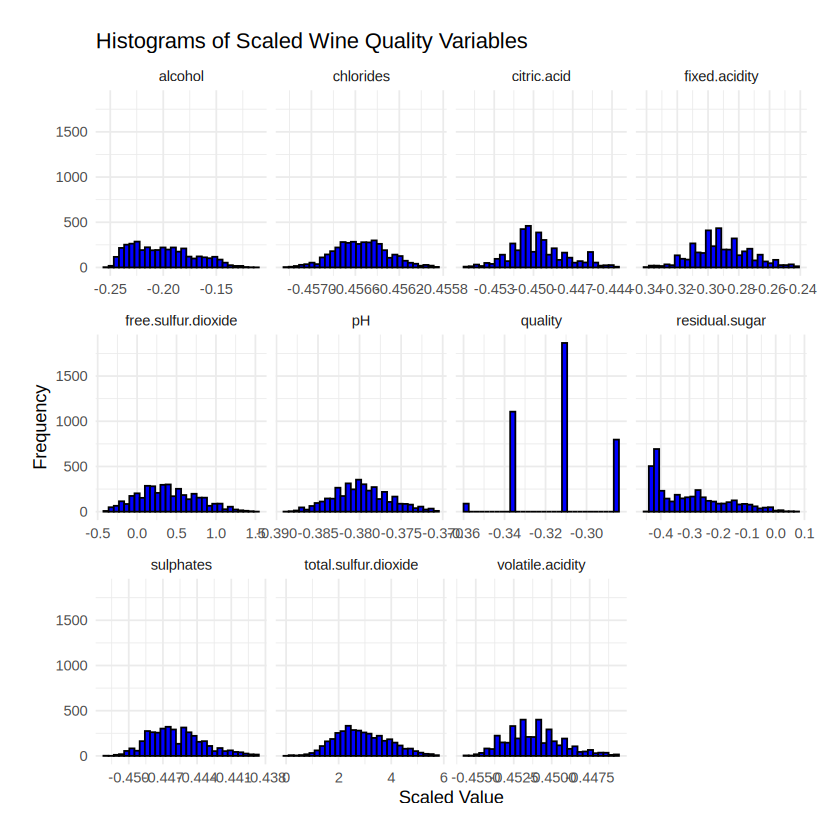

In [25]:
# Converting data to long format and scaling the values
wine_quality_white_long <- wine_quality_white %>%
  pivot_longer(cols = names(wine_quality_white), names_to = "variable", values_to = "value") %>%
  mutate(value = scale(value))  # Scale the data

# 1. Histograms of Scaled Data
ggplot(wine_quality_white_long, aes(x = value)) +
  geom_histogram(bins = 30, fill = "blue", color = "black") +
  facet_wrap(~ variable, scales = "free_x") +
  theme_minimal() +
  theme(plot.margin = margin(20, 20, 20, 20)) +
  labs(title = "Histograms of Scaled Wine Quality Variables",
       x = "Scaled Value",
       y = "Frequency")

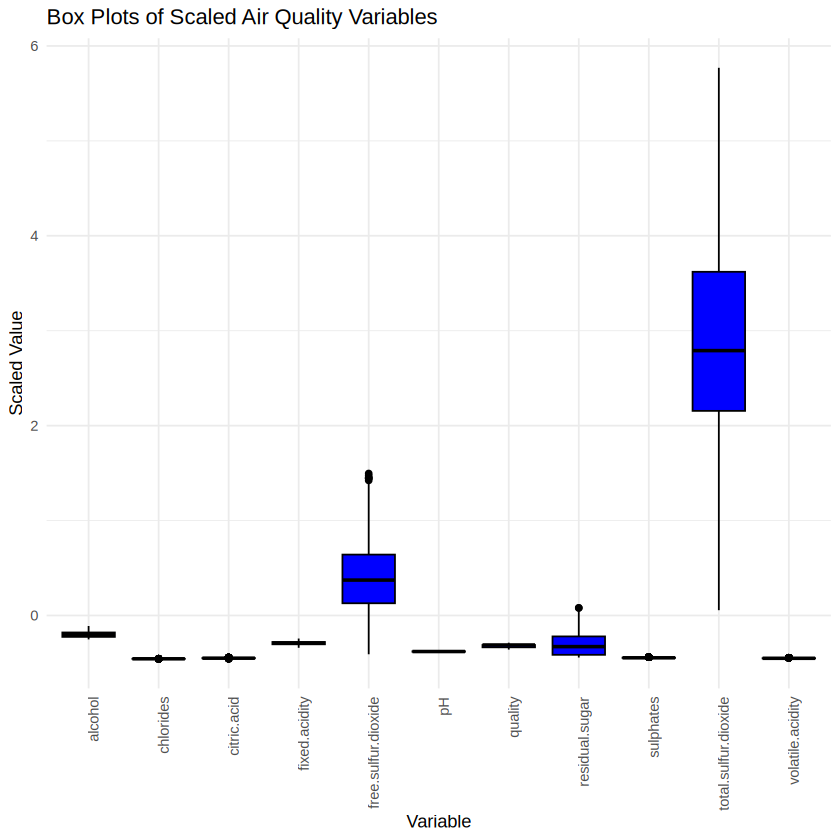

In [26]:
# 2. Box Plots of Scaled Data
ggplot(wine_quality_white_long, aes(x = variable, y = value)) +
  geom_boxplot(fill = "blue", color = "black") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(title = "Box Plots of Scaled Air Quality Variables",
       x = "Variable",
       y = "Scaled Value")

## Phân tích đơn biến

In [27]:
names(wine_quality_white)

[1] "fixed.acidity"        "volatile.acidity"     "citric.acid"         
 [4] "residual.sugar"       "chlorides"            "free.sulfur.dioxide" 
 [7] "total.sulfur.dioxide" "pH"                   "sulphates"           
[10] "alcohol"              "quality"

### Khảo sát biến `fixed.acidity`

[1] "Optimal lambda:  0.383838383838384"


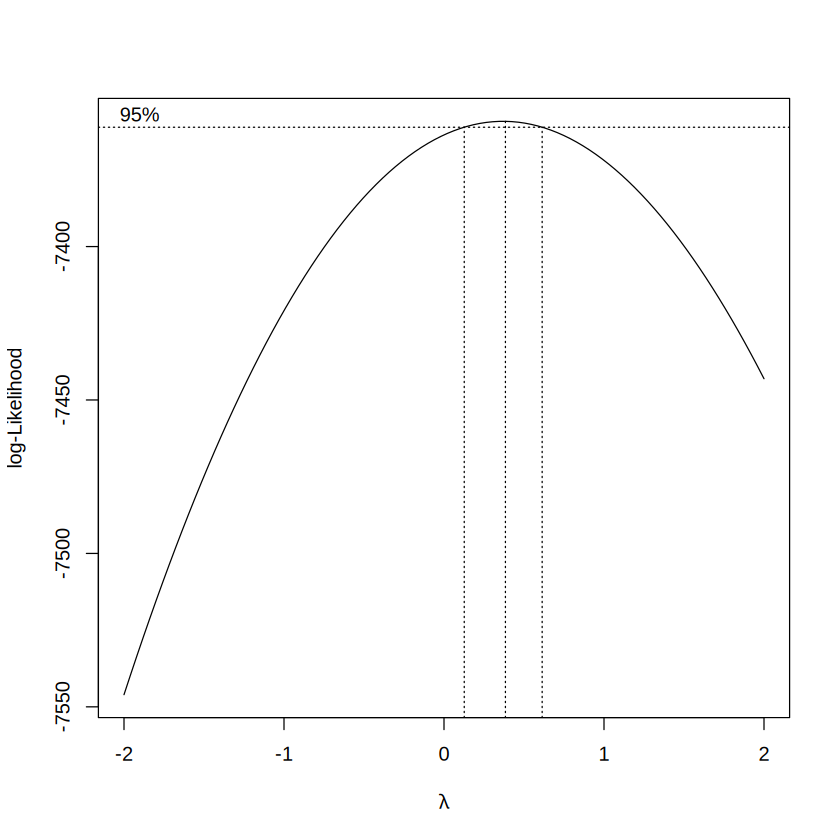

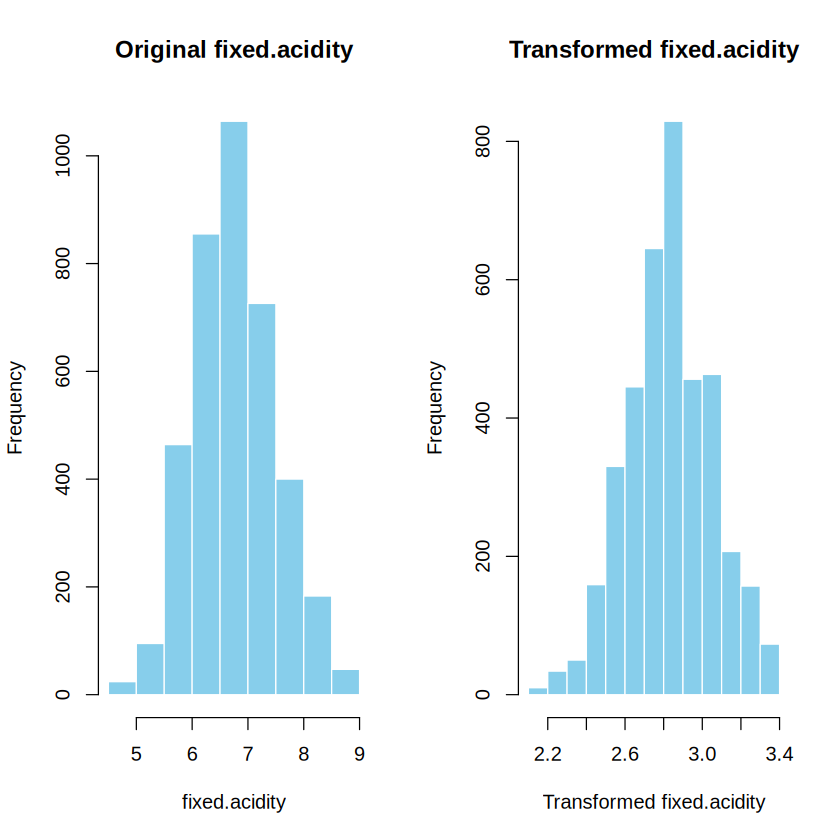

In [28]:
response_variable <- wine_quality_white$fixed.acidity

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original fixed.acidity", xlab = "fixed.acidity", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed fixed.acidity", xlab = "Transformed fixed.acidity", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Khảo sát biến `volatile.acidity`

[1] "Optimal lambda:  0.424242424242424"


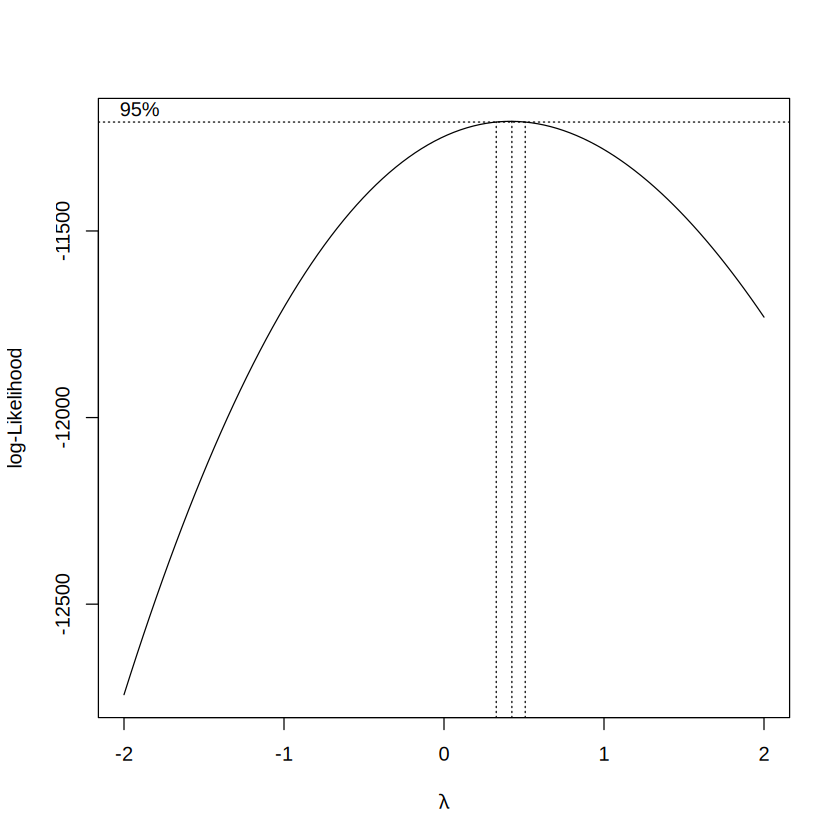

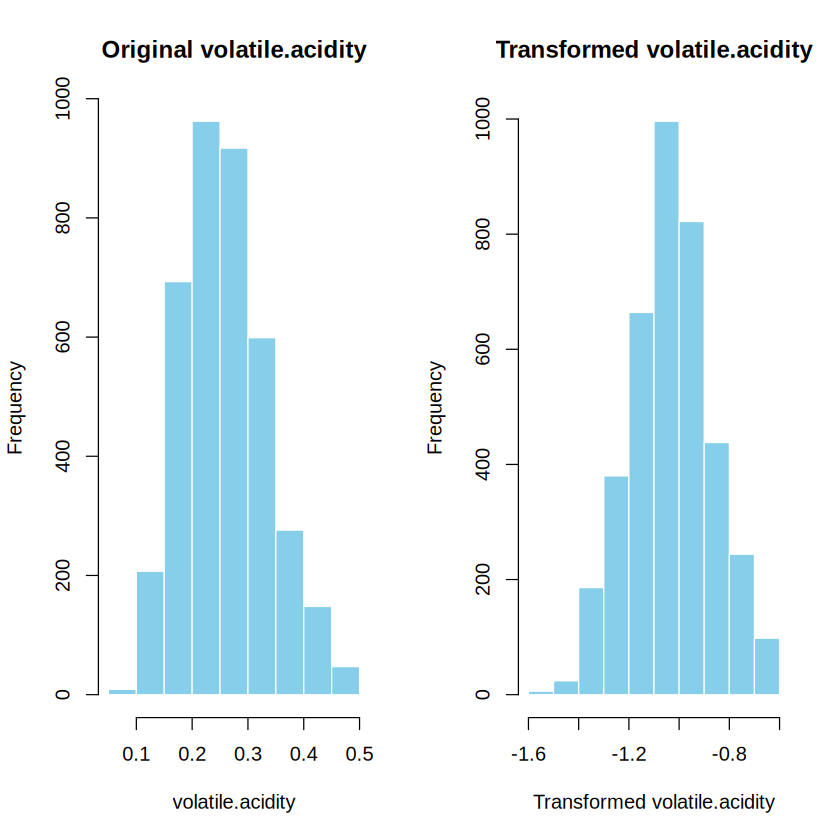

In [29]:
response_variable <- wine_quality_white$volatile.acidity

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original volatile.acidity", xlab = "volatile.acidity", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed volatile.acidity", xlab = "Transformed volatile.acidity", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Khảo sát biến `citric.acid`

[1] "Optimal lambda:  -1.47474747474747"


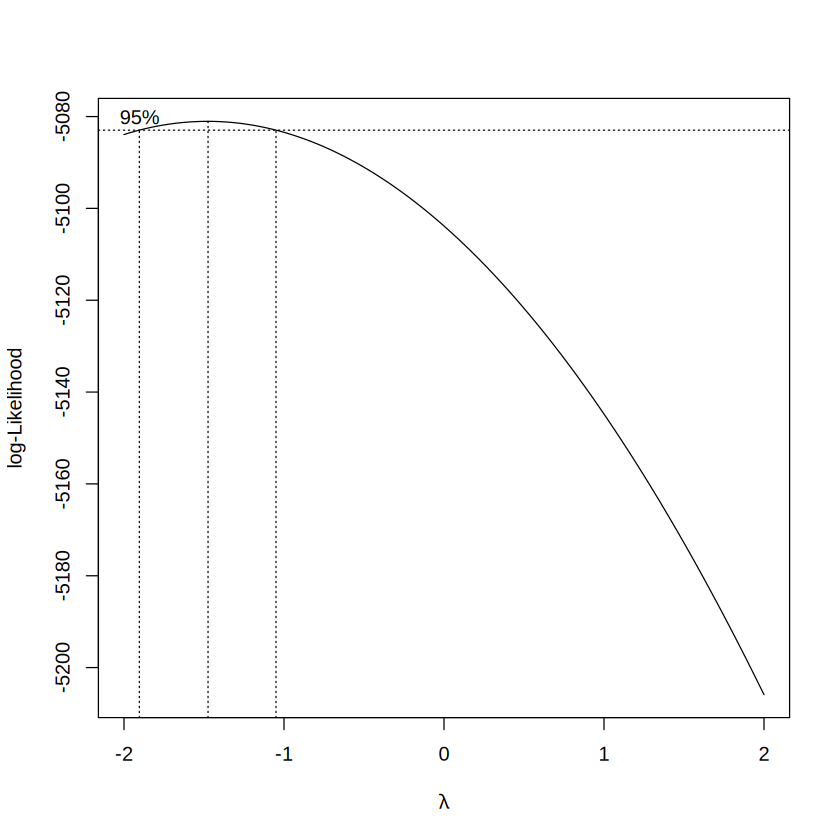

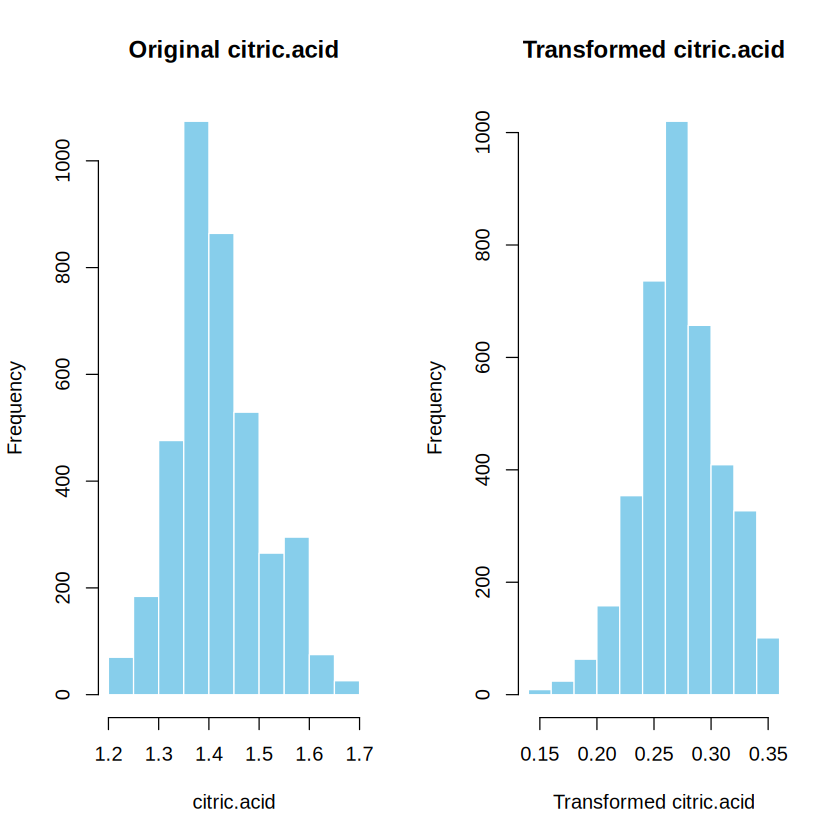

In [30]:
response_variable <- wine_quality_white$citric.acid

# Shift the values to be positive
shift_value <- abs(min(response_variable)) + 1
response_variable <- response_variable + shift_value

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original citric.acid", xlab = "citric.acid", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed citric.acid", xlab = "Transformed citric.acid", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Khảo sát biến `residual.sugar`

[1] "Optimal lambda:  0.141414141414141"


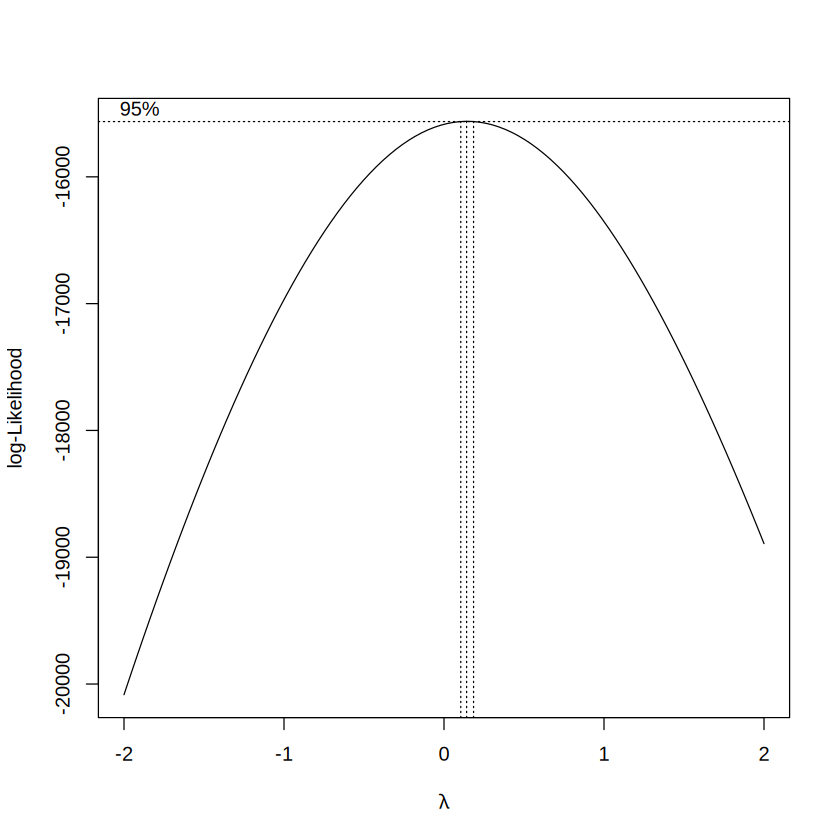

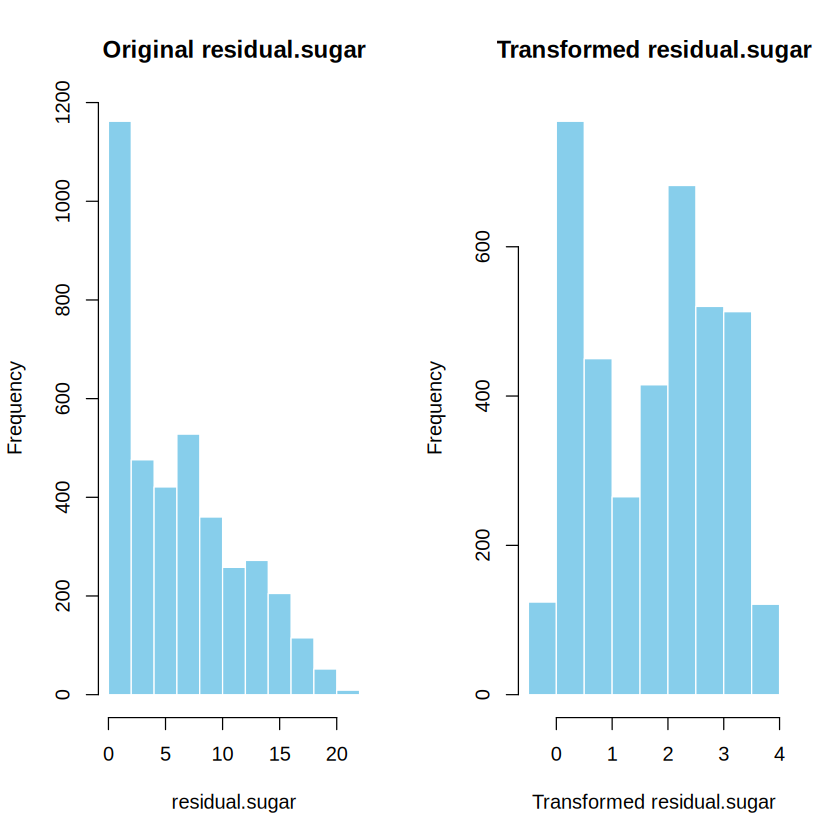

In [31]:
response_variable <- wine_quality_white$residual.sugar

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original residual.sugar", xlab = "residual.sugar", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed residual.sugar", xlab = "Transformed residual.sugar", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Khảo sát biến `chlorides`

[1] "Optimal lambda:  0.868686868686869"


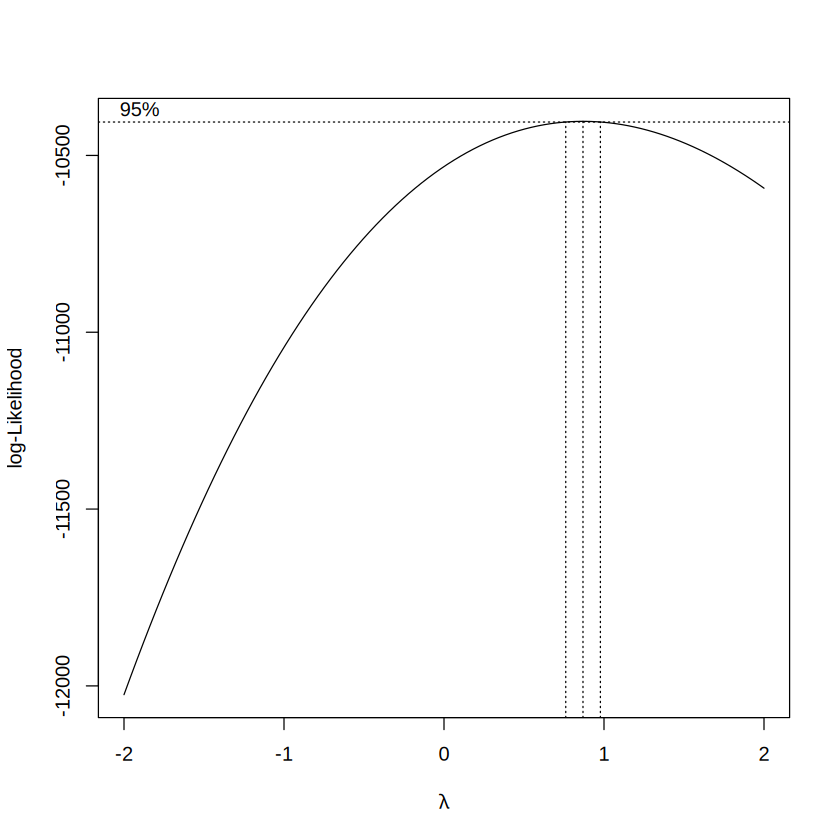

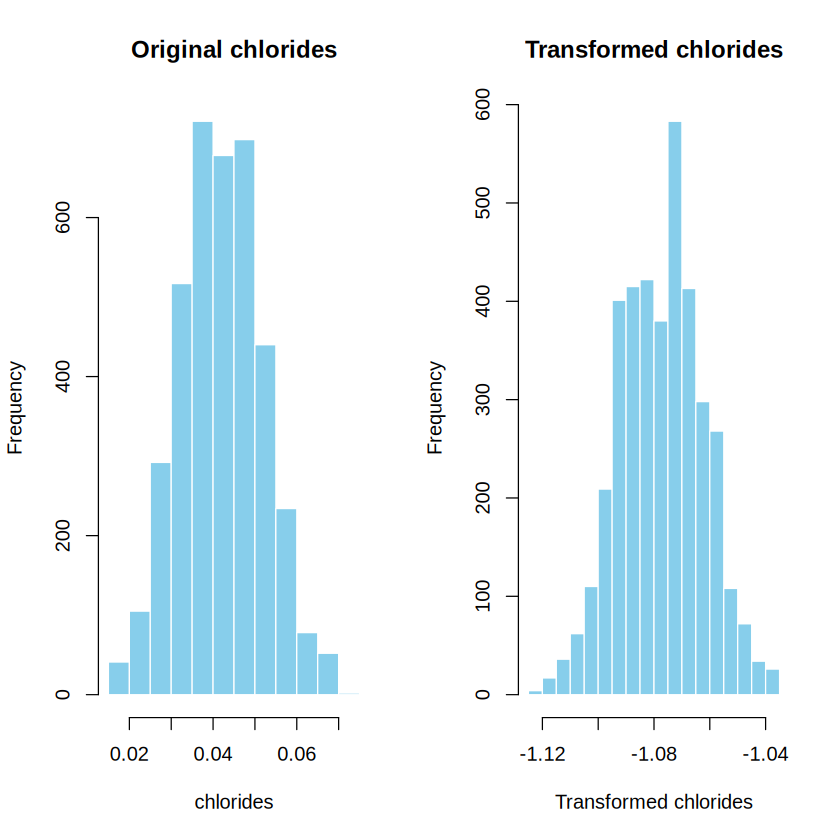

In [32]:
response_variable <- wine_quality_white$chlorides

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original chlorides", xlab = "chlorides", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed chlorides", xlab = "Transformed chlorides", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Khảo sát biến `free.sulfur.dioxide`

[1] "Optimal lambda:  0.666666666666667"


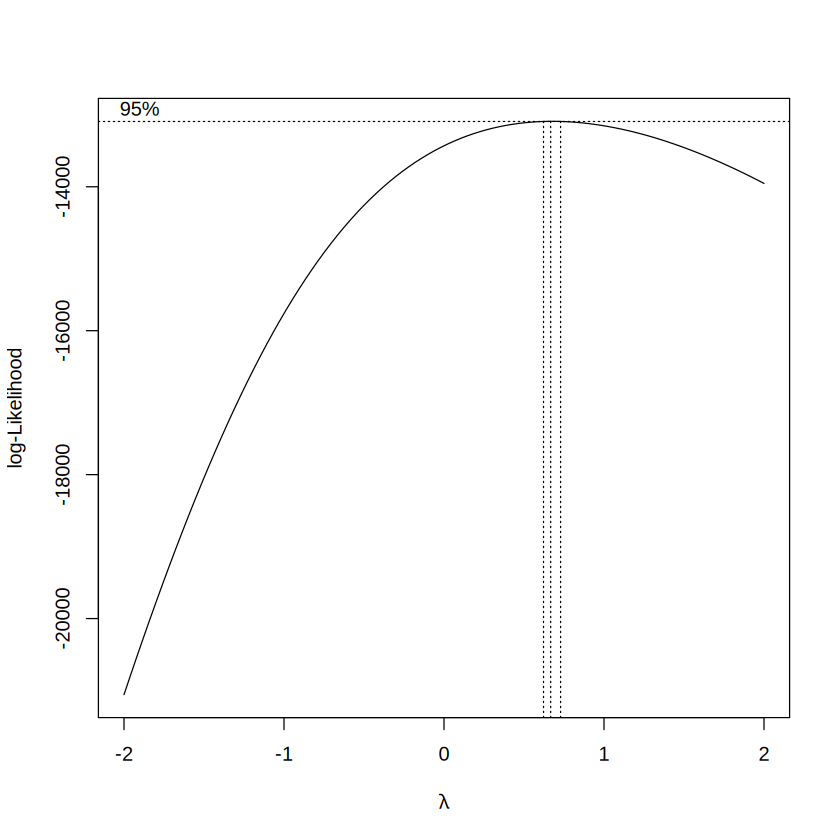

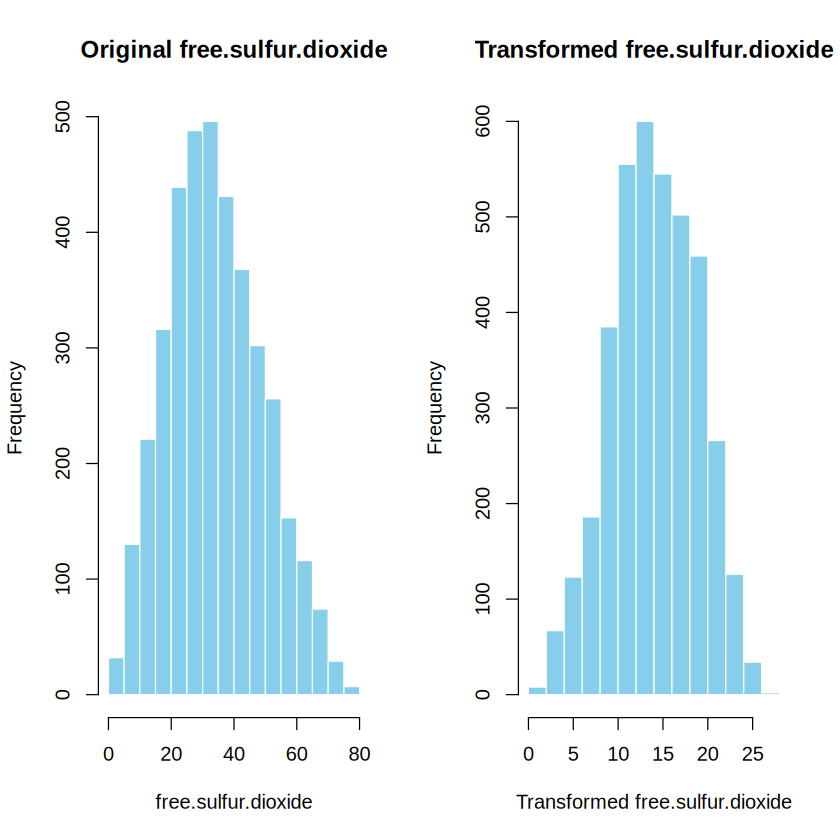

In [33]:
response_variable <- wine_quality_white$free.sulfur.dioxide

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original free.sulfur.dioxide", xlab = "free.sulfur.dioxide", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed free.sulfur.dioxide", xlab = "Transformed free.sulfur.dioxide", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Khảo sát biến `total.sulfur.dioxide`

[1] "Optimal lambda:  0.626262626262626"


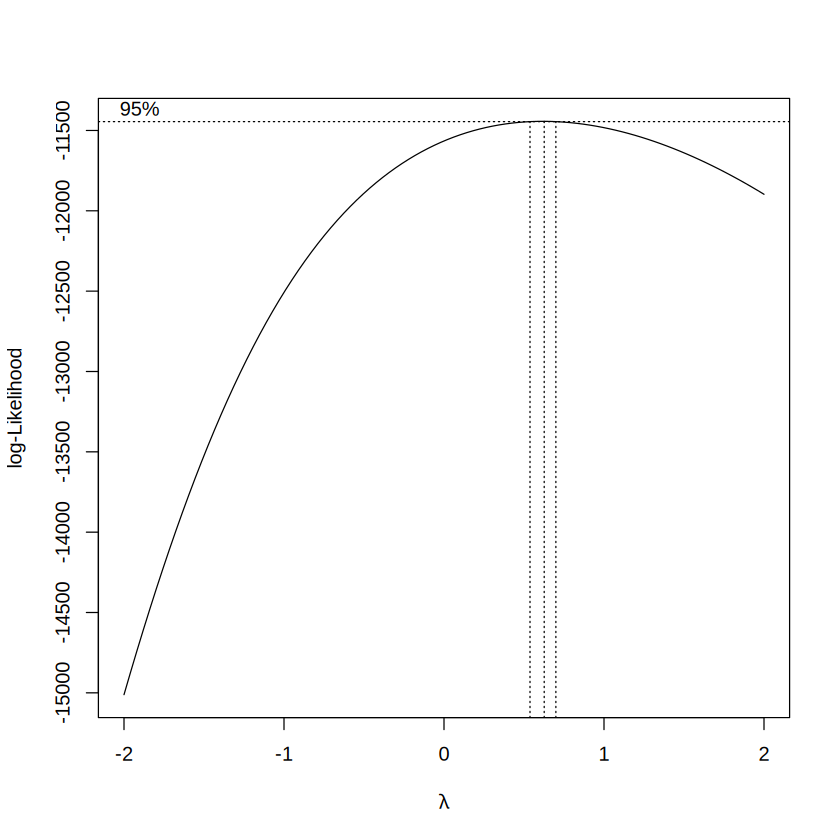

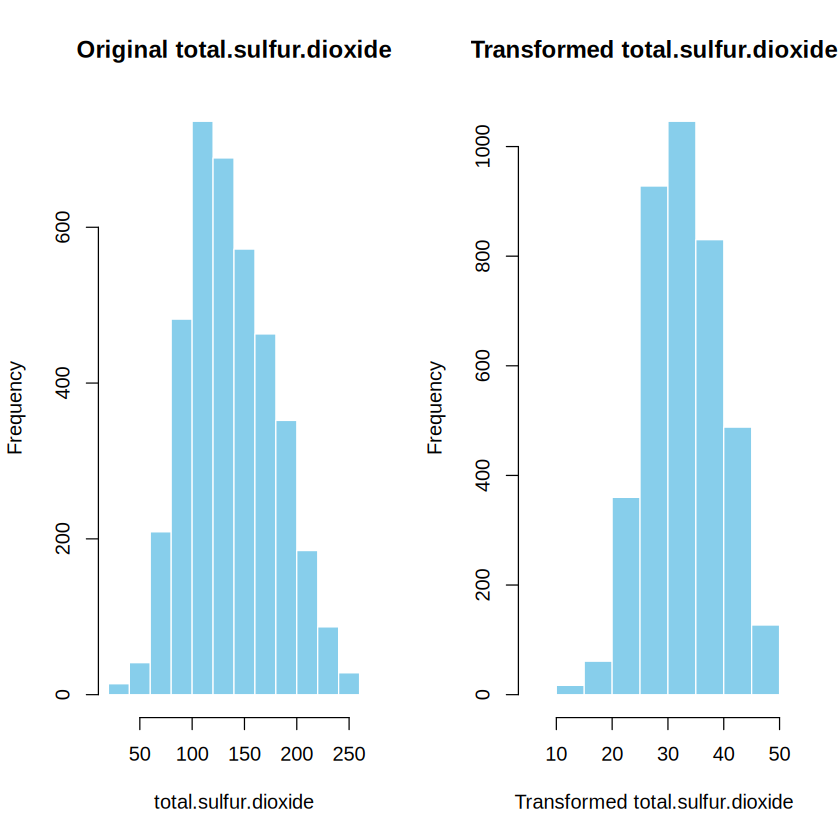

In [34]:
response_variable <- wine_quality_white$total.sulfur.dioxide

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original total.sulfur.dioxide", xlab = "total.sulfur.dioxide", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed total.sulfur.dioxide", xlab = "Transformed total.sulfur.dioxide", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Khảo sát biến `pH`

[1] "Optimal lambda:  -0.747474747474747"


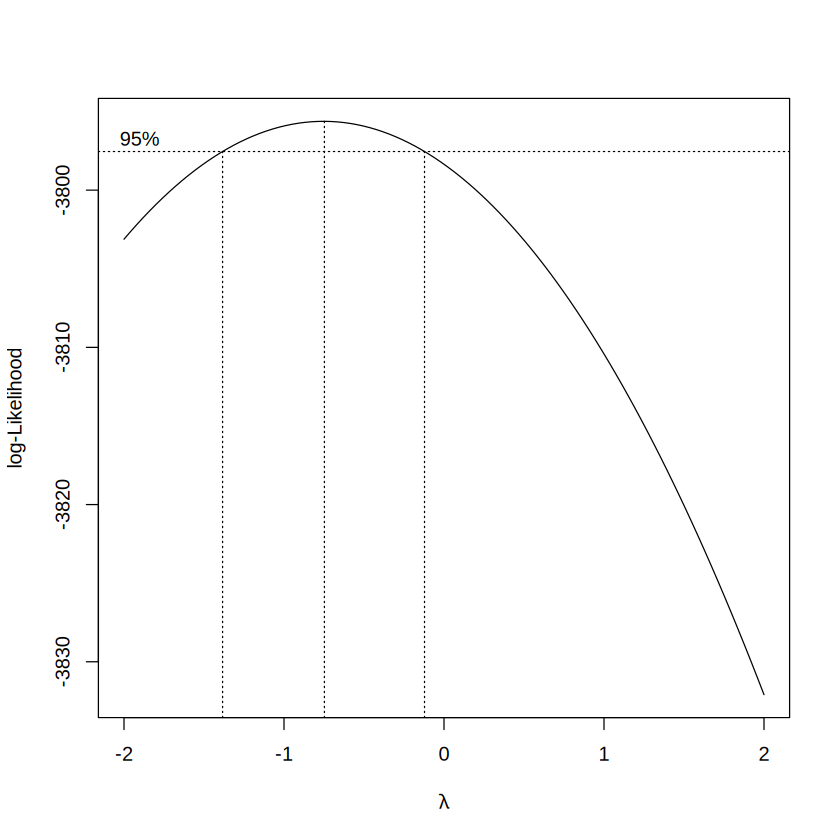

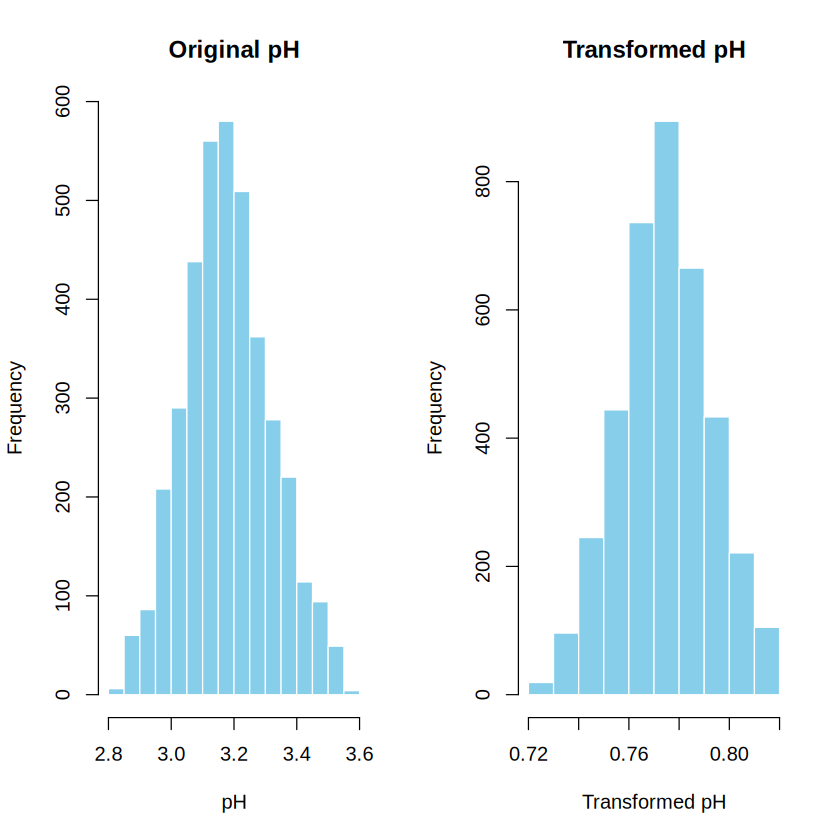

In [35]:
response_variable <- wine_quality_white$pH

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original pH", xlab = "pH", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed pH", xlab = "Transformed pH", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Khảo sát biến `sulphates`

[1] "Optimal lambda:  0.060606060606061"


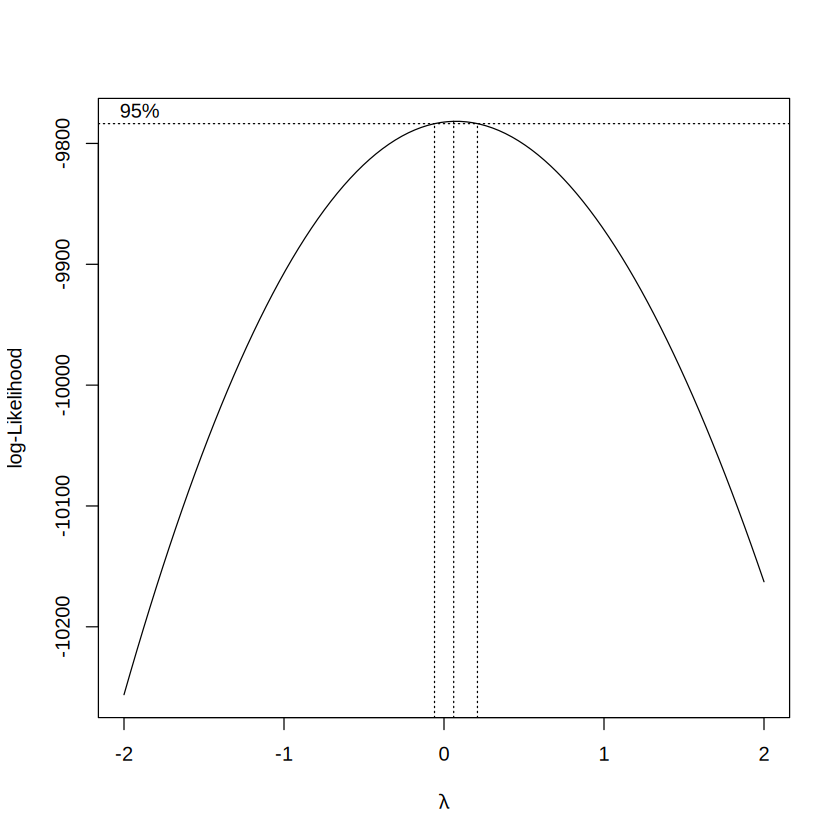

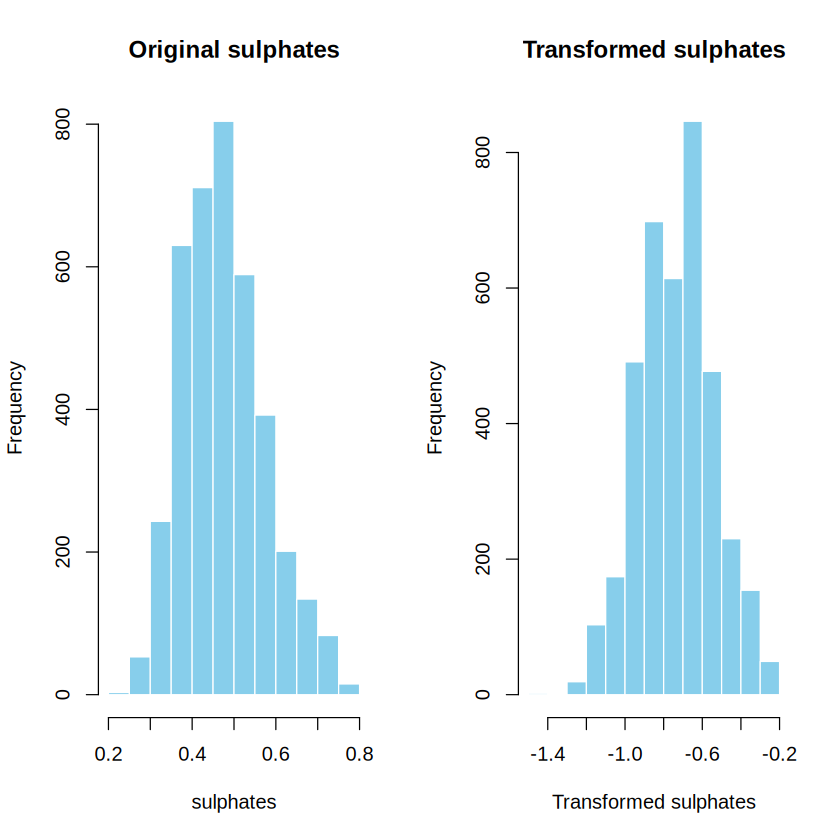

In [36]:
response_variable <- wine_quality_white$sulphates

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original sulphates", xlab = "sulphates", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed sulphates", xlab = "Transformed sulphates", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Khảo sát biến `alcohol` 

[1] "Optimal lambda:  -1.23232323232323"


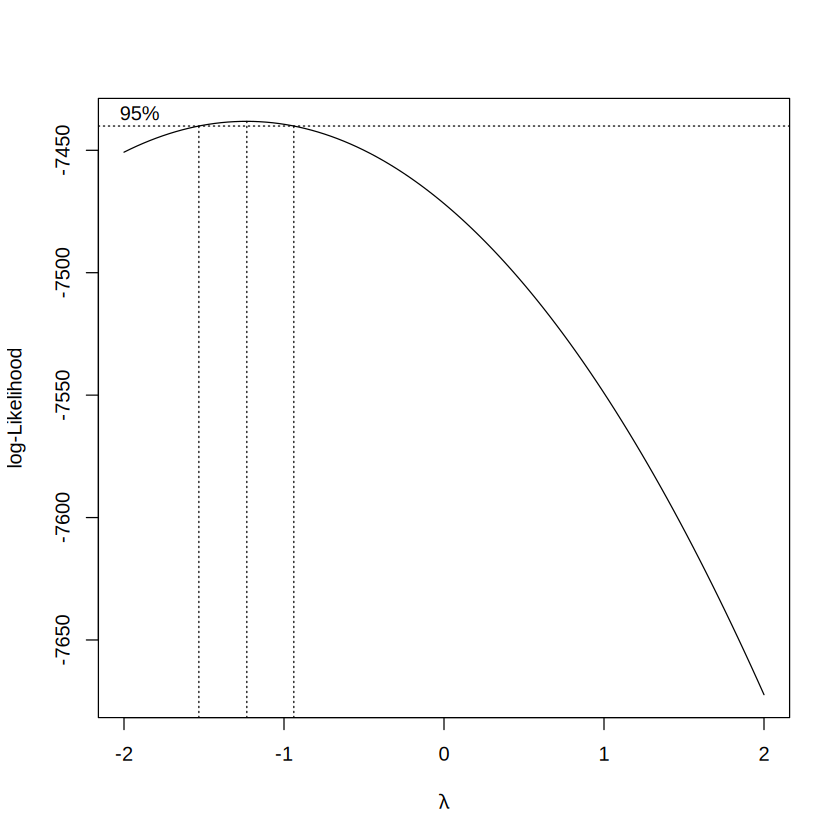

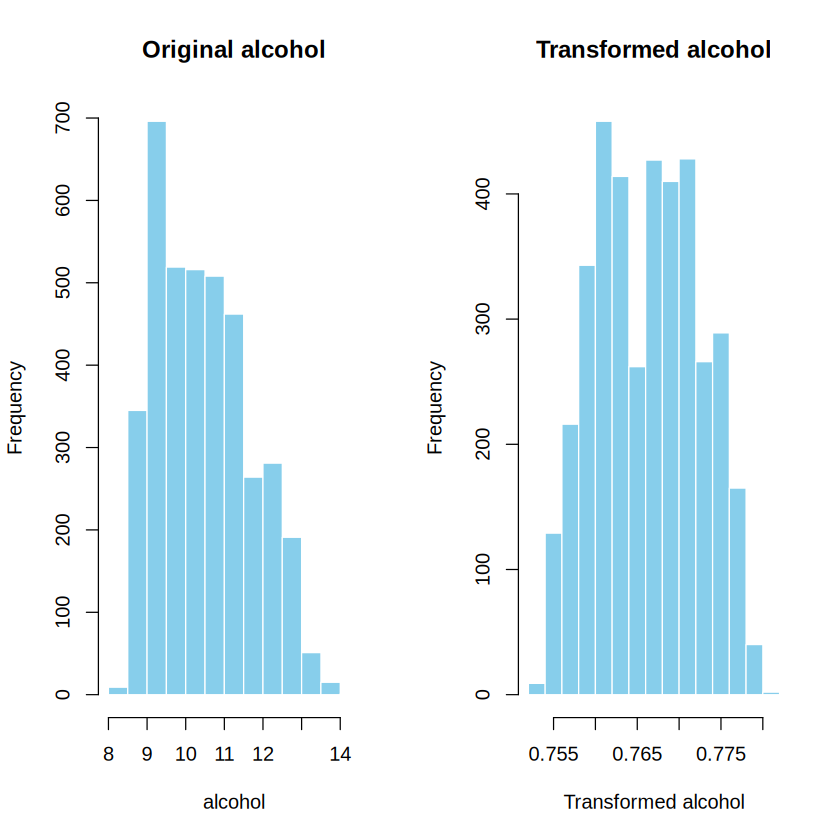

In [37]:
response_variable <- wine_quality_white$alcohol

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original alcohol", xlab = "alcohol", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed alcohol", xlab = "Transformed alcohol", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

### Biến đổi dữ liệu

In [38]:
wine_quality_white <- bc_transform(wine_quality_white)
head(wine_quality_white)

[1] "fixed.acidity"
[1] "Optimal lambda: -1.2"
[1] "volatile.acidity"
[1] "Optimal lambda: -1.2"
[1] "citric.acid"
[1] "Optimal lambda: -1.2"
[1] "residual.sugar"
[1] "Optimal lambda: -1.2"
[1] "chlorides"
[1] "Optimal lambda: -1.2"
[1] "free.sulfur.dioxide"
[1] "Optimal lambda: -1.2"
[1] "total.sulfur.dioxide"
[1] "Optimal lambda: -1.2"
[1] "pH"
[1] "Optimal lambda: -1.2"
[1] "sulphates"
[1] "Optimal lambda: -1.2"
[1] "alcohol"
[1] "Optimal lambda: -1.2"
[1] "quality"
[1] "Optimal lambda: -1.2"


,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.7526654,-3.177016,-2.006257,0.8113722,-33.59878,0.8246844,0.8315783,0.6103496,-1.339186,0.7720363,0.736274
2,0.7417935,-2.700721,-2.207860,0.3592281,-30.25400,0.7982206,0.8309558,0.6344483,-1.128145,0.7774155,0.736274
3,0.7656258,-3.005764,-1.669009,0.7512604,-29.50940,0.8192640,0.8298923,0.6315164,-1.398571,0.7813776,0.736274
4,0.7553468,-4.027888,-2.437352,0.7694311,-24.55915,0.8251241,0.8317579,0.6261905,-1.669009,0.7801156,0.736274
5,0.7553468,-4.027888,-2.437352,0.7694311,-24.55915,0.8251241,0.8317579,0.6261905,-1.669009,0.7801156,0.736274
6,0.7656258,-3.005764,-1.669009,0.7512604,-29.50940,0.8192640,0.8298923,0.6315164,-1.398571,0.7813776,0.736274


## Phân tích đa biến

## Phân chia tập dữ liệu

In [39]:
split_ratio <- 0.8
split_index <- floor(nrow(wine_quality_white) * split_ratio)

train = wine_quality_white[1:split_index,]
test = wine_quality_white[(split_index + 1):nrow(wine_quality_white),]

In [40]:
# số chiều tập train
dim(train)
rownames(train) <- 1:nrow(train)

[1] 3086   11

In [41]:
# số chiều tập test
dim(test)
rownames(test) <- 1:nrow(test)

[1] 772  11

In [42]:
# xem một số quan trắc của tập train
str(train)

'data.frame':	3086 obs. of  11 variables:
 $ fixed.acidity       : num  0.753 0.742 0.766 0.755 0.755 ...
 $ volatile.acidity    : num  -3.18 -2.7 -3.01 -4.03 -4.03 ...
 $ citric.acid         : num  -2.01 -2.21 -1.67 -2.44 -2.44 ...
 $ residual.sugar      : num  0.811 0.359 0.751 0.769 0.769 ...
 $ chlorides           : num  -33.6 -30.3 -29.5 -24.6 -24.6 ...
 $ free.sulfur.dioxide : num  0.825 0.798 0.819 0.825 0.825 ...
 $ total.sulfur.dioxide: num  0.832 0.831 0.83 0.832 0.832 ...
 $ pH                  : num  0.61 0.634 0.632 0.626 0.626 ...
 $ sulphates           : num  -1.34 -1.13 -1.4 -1.67 -1.67 ...
 $ alcohol             : num  0.772 0.777 0.781 0.78 0.78 ...
 $ quality             : num  0.736 0.736 0.736 0.736 0.736 ...


## Mô hình hóa hồi quy tuyến tính đa biến

### Xây dựng mô hình đầy đủ

In [43]:
full.lm <- lm(quality ~ ., data = train)
print(summary(full.lm))


Call:
lm(formula = quality ~ ., data = train)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.068858 -0.009629  0.001931  0.010316  0.045263 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           1.491e-02  2.252e-01   0.066   0.9472    
fixed.acidity        -5.476e-02  2.811e-02  -1.948   0.0515 .  
volatile.acidity     -1.454e-03  1.537e-04  -9.461  < 2e-16 ***
citric.acid           4.125e-04  2.070e-04   1.992   0.0464 *  
residual.sugar        7.960e-03  1.193e-03   6.674 2.95e-11 ***
chlorides            -9.476e-05  2.348e-05  -4.036 5.56e-05 ***
free.sulfur.dioxide   1.971e-01  1.653e-02  11.925  < 2e-16 ***
total.sulfur.dioxide -3.625e-01  2.666e-01  -1.360   0.1741    
pH                    5.073e-02  2.764e-02   1.836   0.0665 .  
sulphates             2.100e-03  5.206e-04   4.035 5.60e-05 ***
alcohol               1.093e+00  5.124e-02  21.339  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’

### Lựa chọn mô hình tốt nhất

In [44]:
# Mô hình chặn dưới
model.lb <- lm(quality ~ 1, data = train)

In [45]:
# Mô hình chặn trên
model.up <- full.lm

In [46]:
step(full.lm, scope = list(lower = model.lb, upper = model.up), direction = "both", trace = FALSE)


Call:
lm(formula = quality ~ fixed.acidity + volatile.acidity + citric.acid + 
    residual.sugar + chlorides + free.sulfur.dioxide + pH + sulphates + 
    alcohol, data = train)

Coefficients:
        (Intercept)        fixed.acidity     volatile.acidity  
         -0.2834438           -0.0561730           -0.0014885  
        citric.acid       residual.sugar            chlorides  
          0.0003951            0.0077106           -0.0001001  
free.sulfur.dioxide                   pH            sulphates  
          0.1849914            0.0477704            0.0020495  
            alcohol  
          1.1057337  


In [60]:
wqr_models <- regsubsets(quality ~ fixed.acidity + volatile.acidity + citric.acid + residual.sugar + chlorides + free.sulfur.dioxide + pH + sulphates + alcohol, data = train)
summary.wqr <-summary(wqr_models)

In [61]:
# Lựa chọn mô hình tốt nhất từ reg subsets
summary.wqr$which

,(Intercept),fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,pH,sulphates,alcohol
1,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE
2,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE
3,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE
4,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE
5,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE
6,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
7,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
8,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE


Tiêu chí chọn mô hình tốt nhất 1: mô hình với $R^2$ lớn (tương ứng với MSE nhỏ)

In [62]:
summary.wqr$rsq

[1] 0.1520201 0.2148287 0.2348947 0.2443920 0.2482515 0.2527319 0.2543961
[8] 0.2551826

Tiêu chí chọn mô hình tốt nhất 2: mô hình với $R^2$ hiệu chỉnh lớn

In [63]:
# model with largest adjusted R^2
summary.wqr$adjr2

[1] 0.1517452 0.2143194 0.2341499 0.2434110 0.2470311 0.2512757 0.2527004
[8] 0.2532462

Tiêu chí chọn mô hình tốt nhất 3: mô hình với Mallow's Cp nhỏ

In [64]:
# model with smallest Mallow's Cp
summary.wqr$cp

[1] 423.46978 165.82488  84.87412  47.61291  33.65818  17.13686  12.25706
[8]  11.00562

#### Chọn mô hình tốt nhất dựa trên BIC

In [65]:
# Tiêu chí chọn mô hình tốt nhất 4: mô hình với BIC nhỏ
summary.wqr$bic

[1] -492.8071 -722.2557 -794.1126 -824.6247 -832.3930 -842.8057 -841.6515
[8] -836.8740

In [66]:
best_model_index <- which.min(summary.wqr$bic)
best_model <- summary.wqr$which[best_model_index, ]
print(best_model)
best_vars <- names(best_model[best_model])
best_vars <- best_vars[best_vars != "(Intercept)"]
print(best_vars)

        (Intercept)       fixed.acidity    volatile.acidity         citric.acid 
               TRUE               FALSE                TRUE               FALSE 
     residual.sugar           chlorides free.sulfur.dioxide                  pH 
               TRUE                TRUE                TRUE               FALSE 
          sulphates             alcohol 
               TRUE                TRUE 
[1] "volatile.acidity"    "residual.sugar"      "chlorides"          
[4] "free.sulfur.dioxide" "sulphates"           "alcohol"            


In [67]:
# Xây dựng mô hình tốt nhất
formula_str <- paste("quality ~", paste(best_vars, collapse = " + "))
best_model_wqr <- lm(as.formula(formula_str), data=train)

In [68]:
# Tóm tắt mô hình
summary(best_model_wqr)


Call:
lm(formula = as.formula(formula_str), data = train)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.070102 -0.009562  0.001889  0.010452  0.045967 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -3.130e-01  4.085e-02  -7.662 2.44e-14 ***
volatile.acidity    -1.552e-03  1.492e-04 -10.402  < 2e-16 ***
residual.sugar       7.608e-03  1.177e-03   6.463 1.19e-10 ***
chlorides           -9.879e-05  2.299e-05  -4.297 1.79e-05 ***
free.sulfur.dioxide  1.872e-01  1.392e-02  13.446  < 2e-16 ***
sulphates            2.263e-03  5.122e-04   4.419 1.02e-05 ***
alcohol              1.124e+00  4.986e-02  22.550  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01472 on 3079 degrees of freedom
Multiple R-squared:  0.2527,	Adjusted R-squared:  0.2513 
F-statistic: 173.6 on 6 and 3079 DF,  p-value: < 2.2e-16


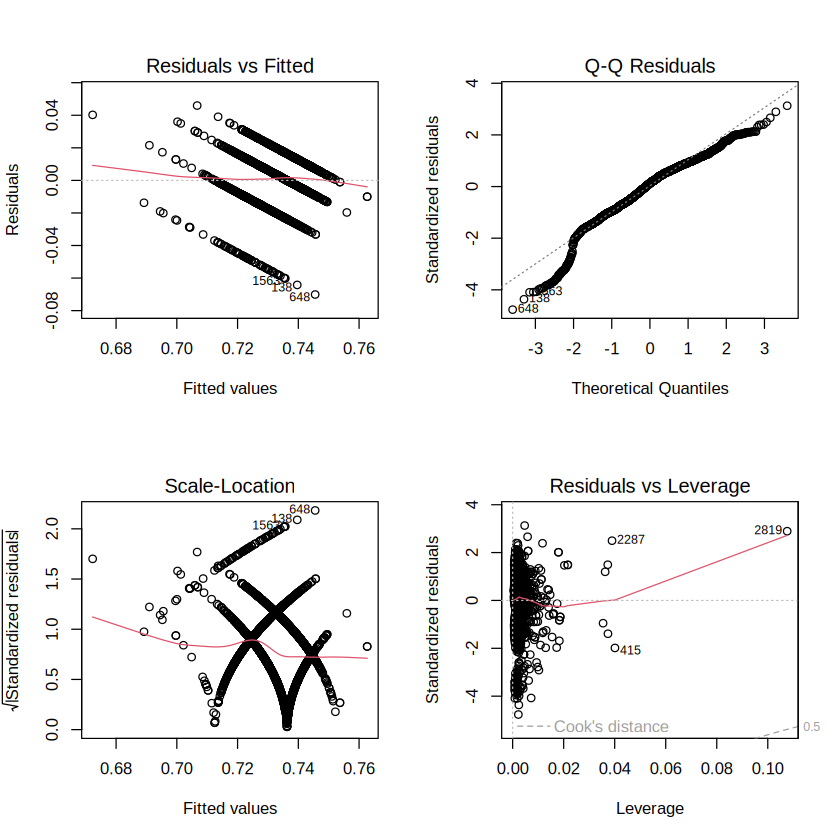

In [69]:
# Trực quan hóa
par(mfrow = c(2, 2))
plot(best_model_wqr)

#### Phân tích Residuals vs Fitted Plot

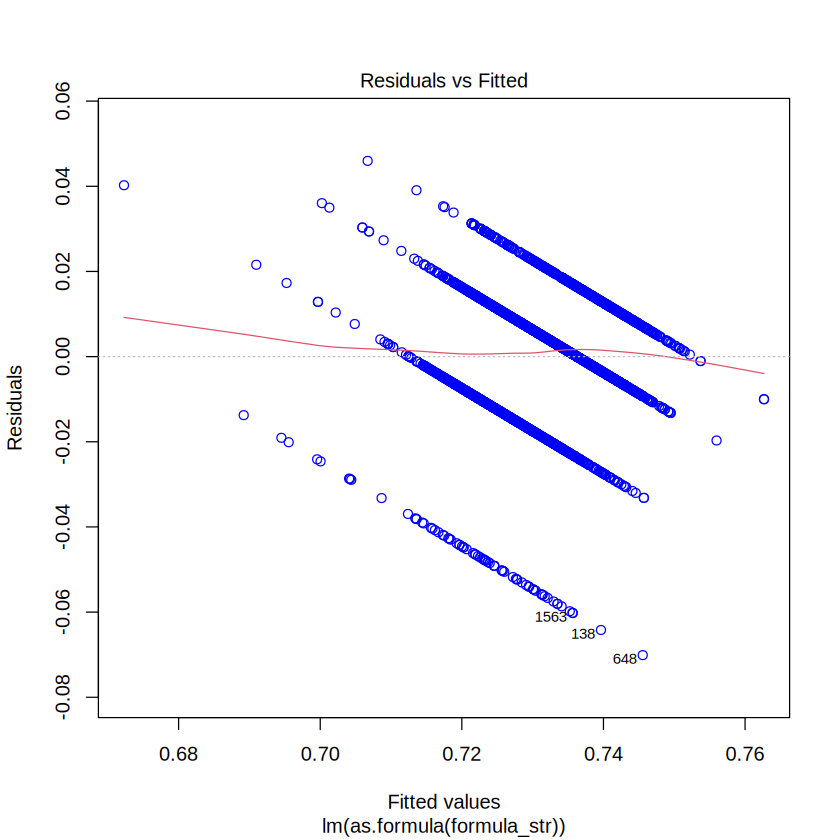

In [70]:
plot(best_model_wqr, which=1, col=c("blue")) # Residuals vs Fitted Plot

#### Phân tích Normal Q–Q (quantile-quantile) Plot


	Shapiro-Wilk normality test

data:  model$residuals
W = 0.96623, p-value < 2.2e-16

[1] "H0 rejected: the residuals are NOT distributed normally"


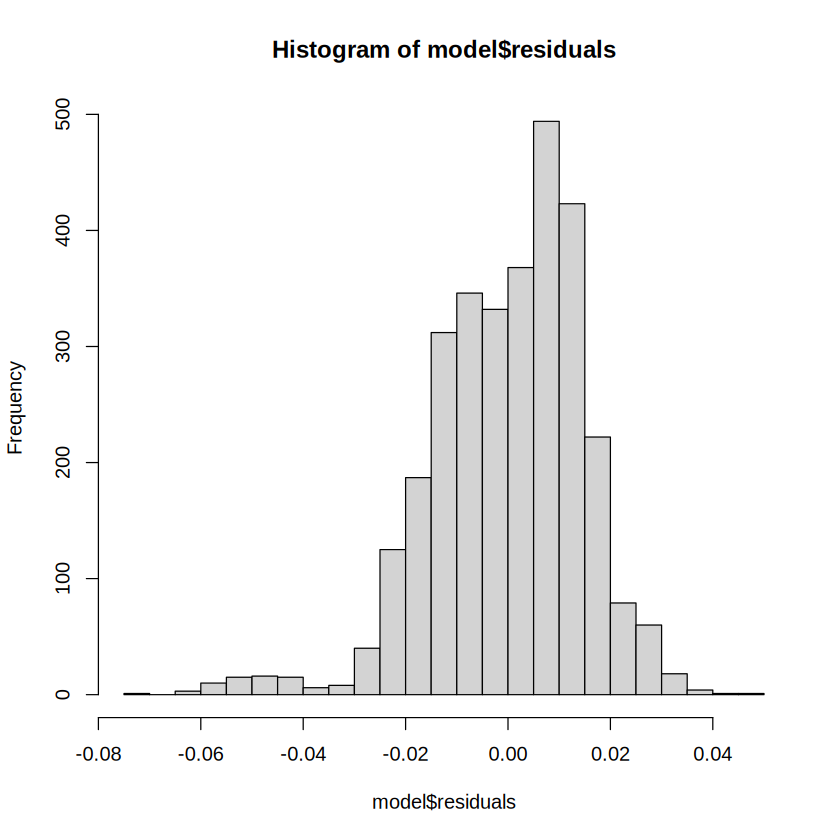

In [71]:
CheckNormal(model = best_model_wqr)

#### Phân tích Scale-Location


	studentized Breusch-Pagan test

data:  model
BP = 120.28, df = 6, p-value < 2.2e-16

[1] "H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)"


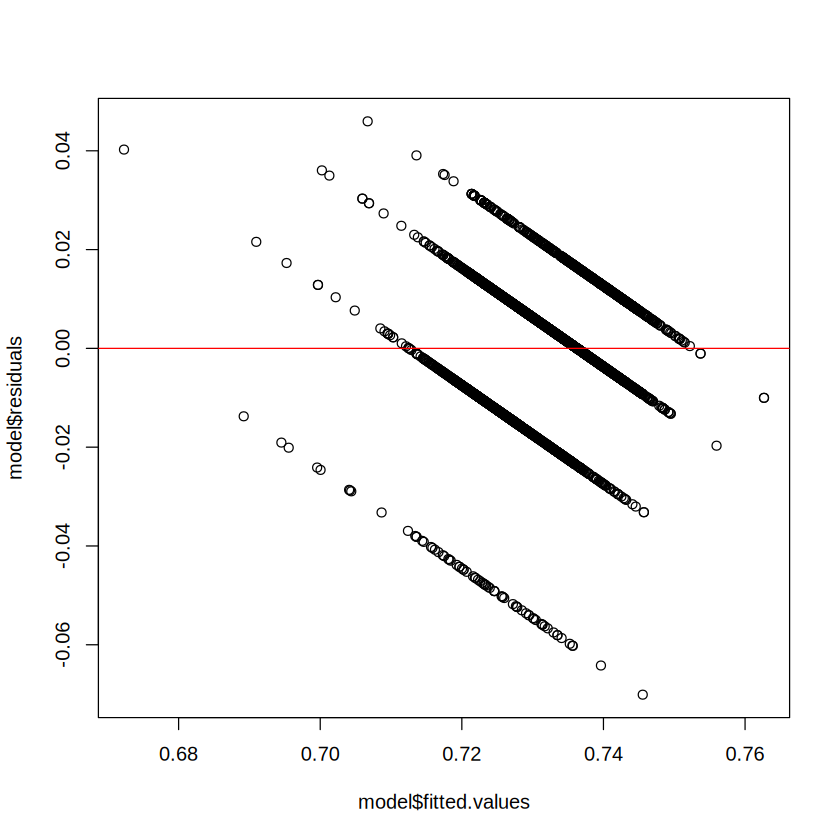

In [72]:
CheckHomos(best_model_wqr)

In [75]:
# Xây dựng ngưỡng cho Cook Distance
threshold <- 4 / nrow(train)
threshold

[1] 0.001296176


Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.032322 -0.009786  0.001157  0.009483  0.033956 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -2.690e-01  3.745e-02  -7.184 8.56e-13 ***
volatile.acidity    -1.548e-03  1.298e-04 -11.927  < 2e-16 ***
residual.sugar       7.296e-03  1.051e-03   6.940 4.82e-12 ***
chlorides           -1.052e-04  2.077e-05  -5.067 4.30e-07 ***
free.sulfur.dioxide  1.578e-01  1.806e-02   8.734  < 2e-16 ***
sulphates            2.047e-03  4.431e-04   4.619 4.02e-06 ***
alcohol              1.100e+00  4.341e-02  25.337  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01237 on 2940 degrees of freedom
Multiple R-squared:  0.2911,	Adjusted R-squared:  0.2897 
F-statistic: 201.3 on 6 and 2940 DF,  p-value: < 2.2e-16



	Shapiro-Wilk normality test

data:  model$residuals
W = 0.98692, p-value = 7.513e-16

[1] "H0 rejected: the residuals are NOT distributed normally"


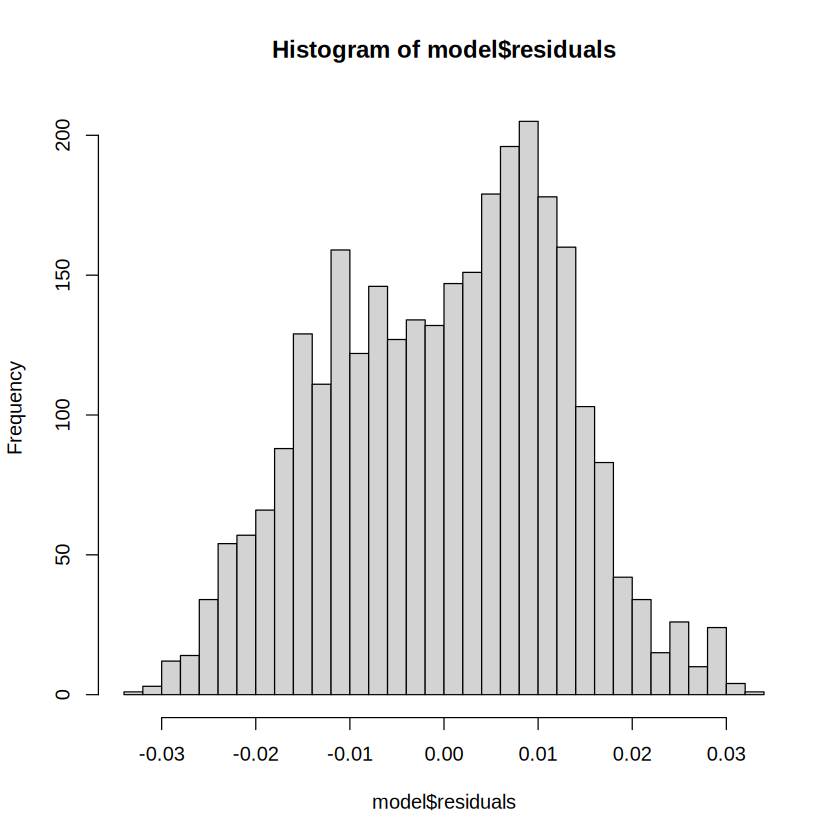


	studentized Breusch-Pagan test

data:  model
BP = 72.67, df = 6, p-value = 1.157e-13

[1] "H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)"


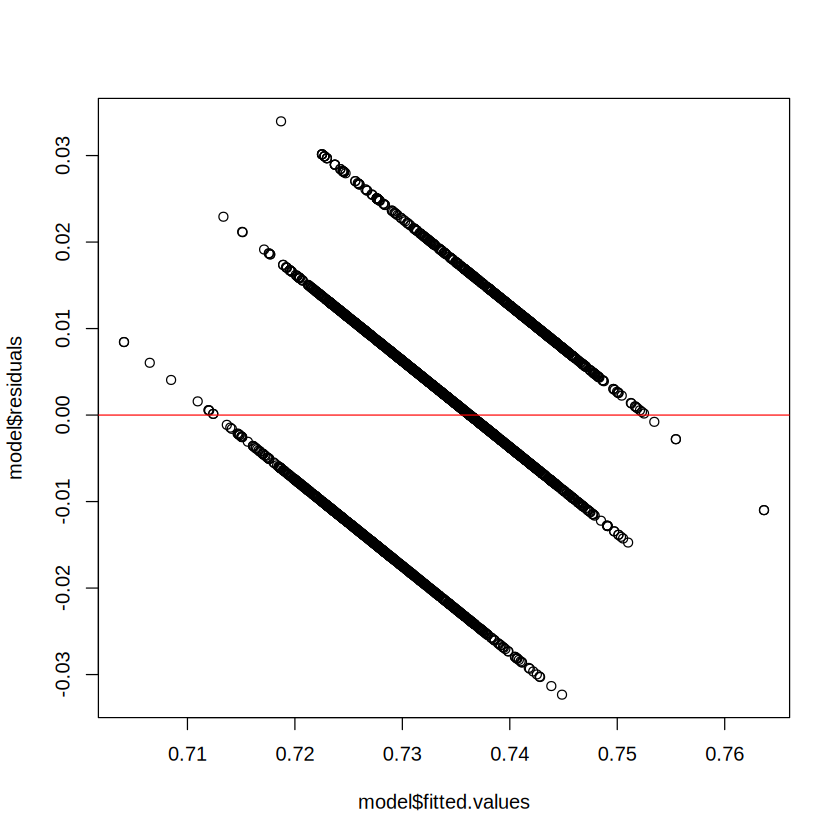

In [76]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_wqr)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_wqr.2 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_wqr.2)

# Shapiro-Wilk normality test
# shapiro.test(residuals(best_model_wqr.2))
CheckNormal(best_model_wqr.2)

# Breusch-Pagan Test
# bptest(best_model_wqr.2)
CheckHomos(best_model_wqr.2)




Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.069849 -0.009621  0.001853  0.010525  0.045795 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -2.986e-01  4.154e-02  -7.188 8.26e-13 ***
volatile.acidity    -1.520e-03  1.516e-04 -10.027  < 2e-16 ***
residual.sugar       7.624e-03  1.198e-03   6.363 2.28e-10 ***
chlorides           -1.074e-04  2.372e-05  -4.529 6.15e-06 ***
free.sulfur.dioxide  1.825e-01  1.421e-02  12.837  < 2e-16 ***
sulphates            2.209e-03  5.225e-04   4.228 2.43e-05 ***
alcohol              1.110e+00  5.073e-02  21.888  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01475 on 2959 degrees of freedom
Multiple R-squared:  0.2507,	Adjusted R-squared:  0.2492 
F-statistic:   165 on 6 and 2959 DF,  p-value: < 2.2e-16



	Shapiro-Wilk normality test

data:  model$residuals
W = 0.96705, p-value < 2.2e-16

[1] "H0 rejected: the residuals are NOT distributed normally"


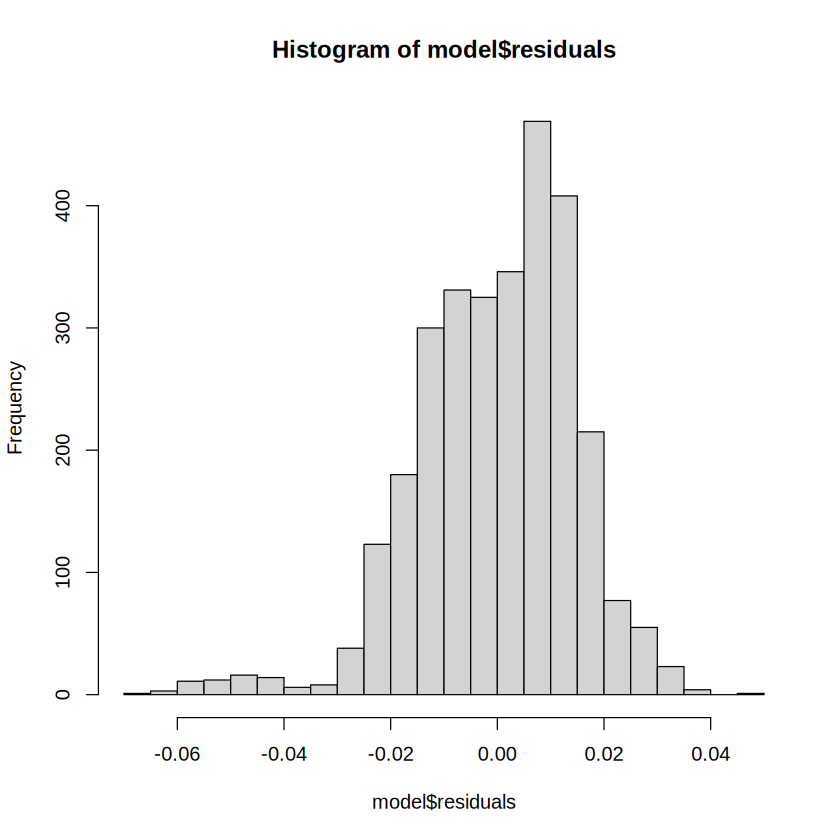


	studentized Breusch-Pagan test

data:  model
BP = 109.47, df = 6, p-value < 2.2e-16

[1] "H0 rejected: Error variance spreads INCONSTANTLY/generating patterns (Heteroscedasticity)"


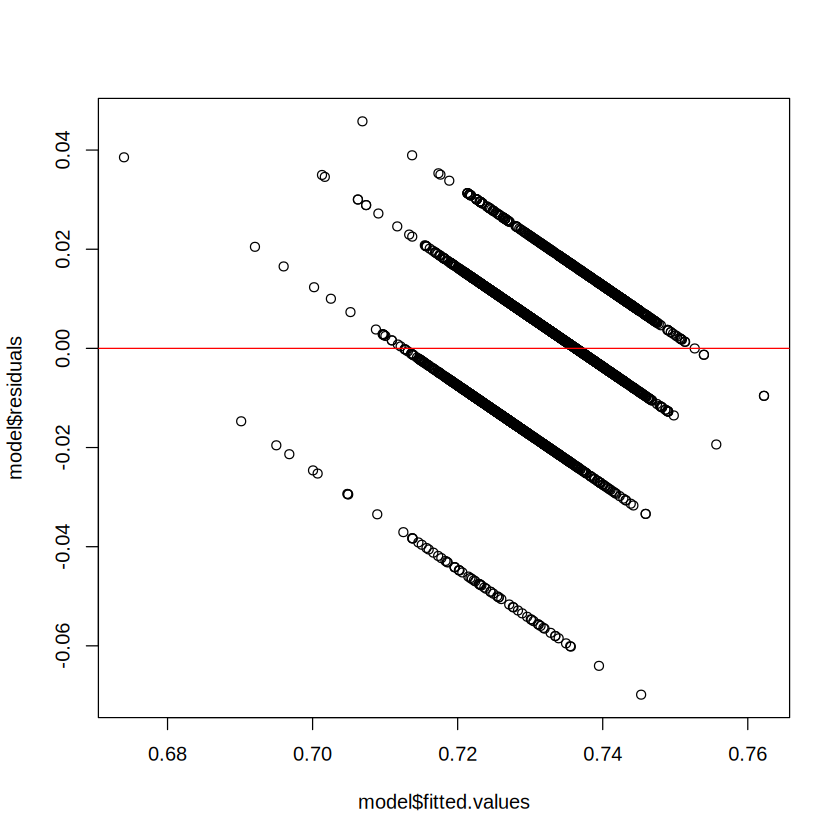

In [77]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_wqr.2)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_wqr.3 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_wqr.3)

# Shapiro-Wilk normality test
CheckNormal(best_model_wqr.3)

# Breusch-Pagan Test
CheckHomos(best_model_wqr.3)

## Đánh giá hiệu suất và dự đoán kết quả

[1] "MSE: 0.000178"
[1] "RMSE: 0.013351"
[1] "MAE: 0.010172"
[1] "Correlation: 0.520108"
[1] "R^2 between y_pred & y_true: 0.270512"


[1] 0.01335099

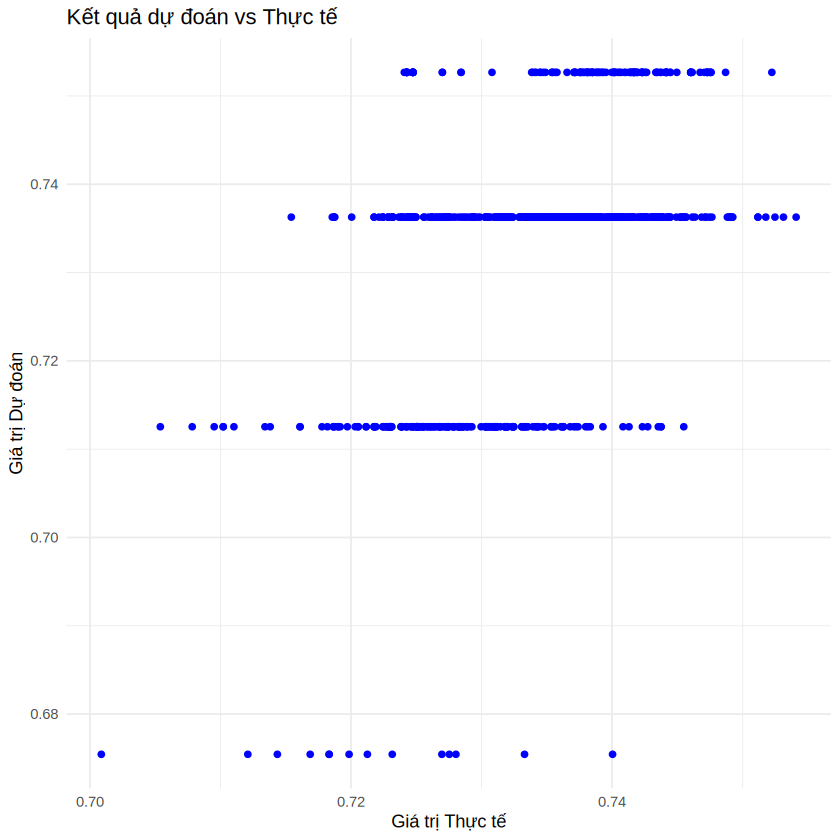

In [78]:
# Dự đoán, tính toán RMSE, và trực quan kết quả dự đoán
results <- predict(best_model_wqr.2, test)
df <- data.frame(
    du_doan <- results,
    label <- test$quality
)

metrics(results, test$quality)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

rmse(results, test$quality)